In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, add, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, multiply
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [ ]:
import os,cv2, random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import normalize
from tensorflow.keras import layers

# Load data volume and preprocessing

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume.npy', 'rb') as f:
    train_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume.npy', 'rb') as f:
    train_masks = np.load(f)

In [ ]:
image_dataset = np.expand_dims(train_images / np.max(train_images), 3) # only the images need normalization
mask_dataset = np.expand_dims(train_masks, 3)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, 
                                                    test_size = 0.20, random_state = 0)

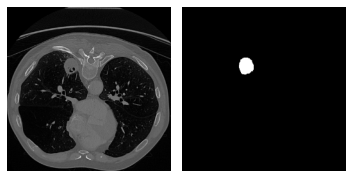

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(5,3))

image_number = random.randint(0,len(train_images))

ax[0].imshow(train_images[image_number,:,:], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(train_masks[image_number,:,:], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

# Loss and Metrics

In [ ]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice_coef = 2 * (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
  return dice_coef

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  jaccard_coef = (intersection + 1.0)/ (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)  # 1 is probably used to avoid nan for 0/0 
  return jaccard_coef

def jaccard_loss(y_true,y_pred):
  return 1.0 -jaccard_coef(y_true, y_pred)


# Model

## Hyperparameters

In [ ]:
input_shape = (256, 256, 1)
patch_size = (4, 4)
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 96  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 8  # Size of attention window
shift_size = window_size // 2  # Size of shifting window
image_dimension = 256  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

## Helper function

In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


## Window Attention

In [ ]:

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


## Patch Encoder

In [ ]:

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim)) # Already flattened


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


## Swin Transformer

In [ ]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## Attention Blocks

In [ ]:
def gating_signal(input, out_size, batch_norm=False):
  '''
  return the gating feature map with the same dimension as the up layer feature map
  kind of like the Conv2DTranspose
  '''
  x = Conv2D(out_size, (1,1), padding='same')(input)
  if batch_norm == True:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [ ]:
def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x) # same usage as numpy.shape
  shape_g = K.int_shape(gating)

  # Getting x to the same shape as the gating signal. 
  theta_x = Conv2D(inter_shape, (2,2), padding='same', strides=(2,2))(x)

  # Getting gating signal to the same number of filter
  phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)

  concat_xg = add([phi_g, theta_x]) # this is actually add not concatenate.

  act_xg = Activation('relu')(concat_xg)

  psi = Conv2D(1, (1,1), padding='same')(act_xg)
  psi = BatchNormalization(axis = 3)(psi)
  
  sigmoid_xg = Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)

  upsample_psi = UpSampling2D(size = (shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

  y = multiply([upsample_psi, x])

  result = Conv2D(shape_x[3], (1,1), padding='same')(y)
  result = BatchNormalization()(result)

  return result


In [ ]:
def conv_block(input, filter_size, filter, dropout_rate, batch_norm = False):
  conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(input)
  if batch_norm == True:
    conv = BatchNormalization(axis = 3)(conv)
  conv = Activation('relu')(conv)

  conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(conv)
  if batch_norm == True:
    conv = BatchNormalization(axis = 3)(conv)
  conv = Activation('relu')(conv)

  if dropout_rate > 0:
    conv = Dropout(dropout_rate)(conv)

  return conv

## Swin Trans Attention Unet (Swin-TAU) 

In [ ]:
def Swin_Trans_Attention(H, W, C, patch_size, dropout_rate=0.1, batch_norm=True):
    FILTER_SIZE = 3
    FILTER_NUM = 64
    UP_SAMPLE_SIZE = 2

    inputs = Input(shape=(H,W,C))

    x = PatchExtract(patch_size)(inputs) # [None, H/4 * W/4, 4**2] = [None, 4096, 16]

    # s1
    s1 = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
    s1 = SwinTransformer(
        dim=embed_dim,
        num_patch=(num_patch_x, num_patch_y),
        num_heads=3,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s1)
    s1 = SwinTransformer(
        dim=embed_dim,
        num_patch=(num_patch_x, num_patch_y),
        num_heads=3,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s1)

    # s2
    s2 = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(s1)
    s2 = SwinTransformer(
        dim=2 * embed_dim,
        num_patch=(num_patch_x // 2, num_patch_y // 2),
        num_heads=6,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s2)
    s2 = SwinTransformer(
        dim=2 * embed_dim,
        num_patch=(num_patch_x // 2, num_patch_y // 2),
        num_heads=6,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s2)

    # s3
    s3 = PatchMerging((num_patch_x // 2, num_patch_y // 2), embed_dim=2 * embed_dim)(s2)
    s3 = SwinTransformer(
        dim=4 * embed_dim,
        num_patch=(num_patch_x // 4, num_patch_y // 4),
        num_heads=12,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s3)
    s3 = SwinTransformer(
        dim=4 * embed_dim,
        num_patch=(num_patch_x // 4, num_patch_y // 4),
        num_heads=12,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s3)
    s3 = SwinTransformer(
        dim=4 * embed_dim,
        num_patch=(num_patch_x // 4, num_patch_y // 4),
        num_heads=12,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s3)
    s3 = SwinTransformer(
        dim=4 * embed_dim,
        num_patch=(num_patch_x // 4, num_patch_y // 4),
        num_heads=12,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s3)
    s3 = SwinTransformer(
        dim=4 * embed_dim,
        num_patch=(num_patch_x // 4, num_patch_y // 4),
        num_heads=12,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s3)
    s3 = SwinTransformer(
        dim=4 * embed_dim,
        num_patch=(num_patch_x // 4, num_patch_y // 4),
        num_heads=12,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s3)

    # s4
    s4 = PatchMerging((num_patch_x // 4, num_patch_y // 4), embed_dim=4 * embed_dim)(s3)
    s4 = SwinTransformer(
        dim=8 * embed_dim,
        num_patch=(num_patch_x // 8, num_patch_y // 8),
        num_heads=24,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s4)
    s4 = SwinTransformer(
        dim=8 * embed_dim,
        num_patch=(num_patch_x // 8, num_patch_y // 8),
        num_heads=24,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(s4)

    z4 = layers.Reshape((8, 8, 8*embed_dim), input_shape=(64, 768))(s4)
    z3 = layers.Reshape((16, 16, 4*embed_dim), input_shape=(256, 284))(s3)
    z2 = layers.Reshape((32, 32, 2*embed_dim), input_shape=(1024, 192))(s2)
    z1 = layers.Reshape((64, 64, embed_dim), input_shape=(4096, 96))(s1)

    c4 = Conv2D(8 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), activation='relu', padding='same', kernel_initializer='he_normal')(z4)
    u4 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c4)
    g4 = gating_signal(c4, FILTER_NUM*4, batch_norm=False)

    c3 = Conv2D(4 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), activation='relu', padding='same', kernel_initializer='he_normal')(z3)
    att3 = attention_block(c3, g4, FILTER_NUM*4)
    concat3 = concatenate([att3, u4])
    c3 = conv_block(concat3, FILTER_SIZE, FILTER_NUM*4, dropout_rate, batch_norm)
    u3 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c3)
    g3 = gating_signal(c3, FILTER_NUM*2, batch_norm=False)
    
    c2 = Conv2D(2 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), activation='relu', padding='same', kernel_initializer='he_normal')(z2)
    att2 = attention_block(c2, g3, FILTER_NUM*2)
    concat2 = concatenate([att2, u3])
    c2 = conv_block(concat2, FILTER_SIZE, FILTER_NUM*2, dropout_rate, batch_norm)
    u2 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c2)
    g2 = gating_signal(c2, FILTER_NUM, batch_norm=False)

    c1 = Conv2D(1 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), activation='relu', padding='same', kernel_initializer='he_normal')(z1)
    att1 = attention_block(c1, g2, FILTER_NUM*1)
    concat1 = concatenate([att1, u2])
    c1 = conv_block(concat1, FILTER_SIZE, FILTER_NUM*1, dropout_rate, batch_norm)
    r1 = layers.Reshape((H // 2, W // 2, 16), input_shape=(64, 64, 64))(c1)
    u1 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(r1)
    g1 = gating_signal(r1, 8, batch_norm=False)

    c0 = Conv2D(8, (FILTER_SIZE, FILTER_SIZE), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    att0 = attention_block(c0, g1, 8)
    concat0 = concatenate([att0, u1])
    c0 = conv_block(concat0, FILTER_SIZE, 8, dropout_rate, batch_norm)

    outputs = Conv2D(1, (1,1), padding='same')(c0)
    outputs = BatchNormalization(axis=3)(outputs)
    outputs = Activation('sigmoid')(outputs)  #Change to softmax for multichannel

    model = Model(inputs = [inputs], outputs = [outputs])
    # model.summary()
    return model


# Load and Train

### Metrics preparation

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume_negative.npy', 'rb') as f:
    negative_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume_negative.npy', 'rb') as f:
    negative_masks = np.load(f)

X_test_negative = np.expand_dims(negative_images / np.max(train_images), 3) # only the images need normalization
y_test_negative = np.expand_dims(negative_masks, 3)

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_images.npy', 'rb') as f:
    X_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_S_masks.npy', 'rb') as f:
    y_test_S = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_images.npy', 'rb') as f:
    X_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_M_masks.npy', 'rb') as f:
    y_test_M = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_images.npy', 'rb') as f:
    X_test_L = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/SMLset/Lung_L_masks.npy', 'rb') as f:
    y_test_L = np.load(f)

In [ ]:
def measure(model, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L):
    
    y_pred = model.predict(X_test)
    negative_pred = model.predict(X_test_negative)
    y_pred_S = model.predict(X_test_S) # running on the positive test set
    y_pred_M = model.predict(X_test_M) # running on the positive test set
    y_pred_L = model.predict(X_test_L) # running on the positive test set

    y_pred_thresholded = y_pred > 0.5

    # IoU (Jaccard)
    intersection = np.logical_and(y_test, y_pred_thresholded)
    union = np.logical_or(y_test, y_pred_thresholded)
    iou = np.sum(intersection) / np.sum(union)

    # Dice
    y_true_f = y_test.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    dice_coef = 2 * (intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

    # Prec, recall, accu
    precision = np.sum(intersection) / np.sum(y_pred_thresholded)
    recall = np.sum(intersection) / np.sum(y_test)

    corr = np.logical_not(np.logical_xor(y_test, y_pred_thresholded))
    accu = int(np.sum(corr)) / (332 * (256 ** 2))

    # Negative dataset
    negative_pred_thresholded = negative_pred > 0.5
    corrN = np.logical_not(np.logical_xor(y_test_negative, negative_pred_thresholded))
    accuN = int(np.sum(corrN)) / (150 * (256 ** 2))

    # SML dataset
    y_true_Sf = y_test_S.flatten()
    y_pred_Sf = y_pred_S.flatten()
    intersection = np.sum(y_true_Sf * y_pred_Sf)
    dice_coef_S = 2 * (intersection + 1e-9) / (np.sum(y_true_Sf) + np.sum(y_pred_Sf) + 1e-9)
    
    y_true_Mf = y_test_M.flatten()
    y_pred_Mf = y_pred_M.flatten()
    intersection = np.sum(y_true_Mf * y_pred_Mf)
    dice_coef_M = 2 * (intersection + 1e-9) / (np.sum(y_true_Mf) + np.sum(y_pred_Mf) + 1e-9)

    y_true_Lf = y_test_L.flatten()
    y_pred_Lf = y_pred_L.flatten()
    intersection = np.sum(y_true_Lf * y_pred_Lf)
    dice_coef_L = 2 * (intersection + 1e-9) / (np.sum(y_true_Lf) + np.sum(y_pred_Lf) + 1e-9)

    return dice_coef, dice_coef_S, dice_coef_M, dice_coef_L, iou, precision, recall, accu, accuN

## Load

In [ ]:
# model takes in 3 parameters H, W, C
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
Swin_TAU = Swin_Trans_Attention(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, patch_size, dropout_rate=0.0, batch_norm=True)

## Train

In [ ]:
Swin_TAU.compile(optimizer='adam',  # tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=0.0001) 
    loss=[dice_loss],
    metrics=[dice_coef, jaccard_coef, 'accuracy'])

In [ ]:
# Define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint_path = '/content/checkpoint/Swin_TAU_lung_TestNotVal_dice_loss_epoch_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

logs = CSVLogger('Swin_TAU_TestNotVal_diceloss_logs.csv', 
                 separator=',', append=False)

callbacks = [logs, checkpoint, checkpoint]

In [ ]:
import datetime
start1 = datetime.datetime.now()

history = Swin_TAU.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split = 0.2)

stop1 = datetime.datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

## Evaluation

In [ ]:
# Evaluate on test set
dice_coef, dice_coef_S, dice_coef_M, dice_coef_L, iou, precision, recall, accu, accuN = measure(Swin_TAU, X_test, y_test, X_test_negative, y_test_negative, 
            X_test_S, y_test_S, X_test_M, y_test_M, X_test_L, y_test_L)
print(f'DSC: {dice_coef}, \n DSC_S: {dice_coef_S},  DSC_M: {dice_coef_M}, DSC_L: {dice_coef_L}, \n iou: {iou}, \n precision: {precision}, recall: {recall}, \n accu: {accu}, accuN: {accuN}')

DSC: 0.7420937296032586, 
 DSC_S: 0.24368377232054972,  DSC_M: 0.6306377647252113, DSC_L: 0.8187287401167281, 
 iou: 0.6197692298663036, 
 precision: 0.7119016669766736, recall: 0.845068072375611, 
 accu: 0.9970224219632436, accuN: 0.991463623046875
